This jupyter notebook is for data acquisition with Fouier ptychography microscope. 

The method is to light up the LEDs in the array sequentially from the center in a spiral pattern. This arrangement has the property that the first n^2 images correspond to the central nxn grid, from n=1->16. Additionally, the starting LED is always the same one (7,7), which is useful for reconstruction. 

In [1]:
from RPiCameraApp import RPiCameraApp
from RPiLedMatrix import RPiLedMatrix
from picamera2 import Picamera2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import numpy as np
 

In [14]:
# Preview using camera app
led_matrix = RPiLedMatrix()
led_matrix.set_rotation(0)
# led_matrix.show_circle(radius=4, color='black', outside_color='white') # darkfield
led_matrix.show_circle(radius=4, color='white') # brightfield

camera_app = RPiCameraApp()
camera_app.run()

led_matrix.off()
led_matrix.close()

[0:35:27.569933804] [3308]  INFO Camera camera_manager.cpp:316 libcamera v0.3.1+50-69a894c4
[0:35:27.584326626] [3367]  INFO RPI pisp.cpp:695 libpisp version v1.0.7 28196ed6edcf 29-08-2024 (16:33:32)
[0:35:27.603505488] [3367]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a to CFE device /dev/media2 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[0:35:27.613326918] [3308]  INFO Camera camera.cpp:1191 configuring streams: (0) 1456x1088-BGR888 (1) 1456x1088-YUV420 (2) 1456x1088-BGGR_PISP_COMP1
[0:35:27.613570103] [3367]  INFO RPI pisp.cpp:1450 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a - Selected sensor format: 1456x1088-SBGGR10_1X10 - Selected CFE format: 1456x1088-PC1B
[0:35:27.621818742] [3308]  INFO Camera camera.cpp:1191 configuring streams: (0) 640x480-XBGR8888 (1) 1456x1088-BGGR_PISP_COMP1
[0:35:27.623263830] [3367]  INFO RPI pisp.cpp:1450 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a - Selected sensor format: 14

HdrMode
<class 'int'>
0
AeFlickerPeriod
<class 'int'>
100
AeFlickerMode
<class 'int'>
0
StatsOutputEnable
<class 'bool'>
False
Other controls ['HdrMode', 'AeFlickerPeriod', 'AeFlickerMode', 'StatsOutputEnable']
Not setting pic controls when not visible
Not setting vid controls when not visible
Not setting vid controls when not visible
Switch to photo
Switching to preview
Not setting vid controls when not visible
Not setting pic controls when not visible


[0:35:28.078323235] [3308]  INFO Camera camera.cpp:1191 configuring streams: (0) 640x480-XBGR8888 (1) 1456x1088-BGGR_PISP_COMP1
[0:35:28.078504623] [3367]  INFO RPI pisp.cpp:1450 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a - Selected sensor format: 1456x1088-SBGGR10_1X10 - Selected CFE format: 1456x1088-PC1B


Not setting vid controls when not visible
Not setting pic controls when not visible
Switching to still
Not setting vid controls when not visible
Not setting pic controls when not visible
Not setting vid controls when not visible
Not setting pic controls when not visible
Switching to preview
Not setting vid controls when not visible
Not setting pic controls when not visible
Not setting vid controls when not visible
Not setting pic controls when not visible
Switching to still
Not setting vid controls when not visible
Not setting pic controls when not visible
Not setting vid controls when not visible
Not setting pic controls when not visible
Switching to preview
Not setting vid controls when not visible
Not setting pic controls when not visible
Not setting vid controls when not visible
Not setting pic controls when not visible


[0:35:28.655808416] [3308]  INFO Camera camera.cpp:1191 configuring streams: (0) 1456x1088-BGR888 (1) 1456x1088-YUV420 (2) 1456x1088-BGGR_PISP_COMP1
[0:35:28.658410519] [3367]  INFO RPI pisp.cpp:1450 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a - Selected sensor format: 1456x1088-SBGGR10_1X10 - Selected CFE format: 1456x1088-PC1B
[0:35:28.726815308] [3308]  INFO Camera camera.cpp:1191 configuring streams: (0) 800x596-XBGR8888 (1) 1456x1088-BGGR_PISP_COMP1
[0:35:28.729740076] [3367]  INFO RPI pisp.cpp:1450 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a - Selected sensor format: 1456x1088-SBGGR10_1X10 - Selected CFE format: 1456x1088-PC1B
[0:35:28.786644405] [3308]  INFO Camera camera.cpp:1191 configuring streams: (0) 1456x1088-BGR888 (1) 1456x1088-YUV420 (2) 1456x1088-BGGR_PISP_COMP1
[0:35:28.789583191] [3367]  INFO RPI pisp.cpp:1450 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a - Selected sensor format: 1456x1088-SBGGR10_1X10 - Selected CFE format: 1456x1088-PC1

In [4]:
# Starting at 7,7, generate coordinates to turn on LEDs in a spiral pattern, moving right up left down right up left down....
# 0,0 is bottom left LED when rotation is 135 degrees
def LED_spiral(n):
    # Initialize the arrays to store the x and y coordinates
    x_coords = np.zeros(n**2, dtype=int)
    y_coords = np.zeros(n**2, dtype=int)
    
    # Starting point
    x, y = 7, 7
    x_coords[0], y_coords[0] = x, y
    
    step_size = 1  # How far to move in each direction before changing direction
    index = 1  # Tracks the number of coordinates generated so far
    
    while index < n**2:
        # Move right
        for _ in range(step_size):
            if index >= n**2:
                break
            x += 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        # Move up
        for _ in range(step_size):
            if index >= n**2:
                break
            y += 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        step_size += 1  # Increase step size after moving right and up
        
        # Move left
        for _ in range(step_size):
            if index >= n**2:
                break
            x -= 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        # Move down
        for _ in range(step_size):
            if index >= n**2:
                break
            y -= 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        step_size += 1  # Increase step size after moving left and down
    
    return x_coords, y_coords

# # Example usage
# n = 16  # Example, for a 5x5 grid
# x, y = LED_spiral(n)
# print("X coordinates:", x, len(x))
# print("Y coordinates:", y, len(y))


In [8]:
camera.stop()
camera.close()

In [29]:
# Gather grayscale images for Fourier ptychography

output_folder = 'data/usaf_light' # should be an empty folder
gridSize = 16 # can use 1 for testing and alignment, then set to 16 to capture full dataset

led_matrix = RPiLedMatrix()
led_matrix.set_rotation(135) # ensure 0,0 is bottom left pixel

# set up camera - way to automate?
exposure = 20000 # in us, 40000
crop_start_x = 450 # from left of image
crop_start_y = 530 # from top of image
crop_size = 380
camera = Picamera2()
still_config = camera.create_still_configuration(main={'size':(1456,1088)}, controls = {'ExposureTime':exposure, "AnalogueGain": 1})
camera.configure(still_config)
camera.start()

x,y = LED_spiral(gridSize) # generates arrays for x and y to turn on LEDs in spiral pattern

# take a brightfield image for comparison
led_matrix.show_circle(radius=2, color='white', brightness=1 )
time.sleep(1)
img_arr = camera.capture_array()[crop_start_y:crop_start_y+crop_size,crop_start_x:crop_start_x+crop_size] # capture and crop
img_pil = Image.fromarray(img_arr) # convert to pillow object
img_pil_gray = img_pil.convert('L') # convert to grayscale 
img_path = os.path.join(output_folder, 'brightfield.png') # create path name
img_pil_gray.save(img_path, format='PNG') # save as png 

# take fpm images
for i in range(len(x)):
        led_matrix.show_pixel(x[i],y[i],brightness=1)
        time.sleep(0.1) # short pause for LED
        img_arr = camera.capture_array()[crop_start_y:crop_start_y+crop_size,crop_start_x:crop_start_x+crop_size] # capture and crop
        img_pil = Image.fromarray(img_arr) # convert to pillow object
        img_pil_gray = img_pil.convert('L') # convert to grayscale 
        
        img_path = os.path.join(output_folder, f'image_{i}.png') # create path name
        img_pil_gray.save(img_path, format='PNG') # save as png 
        
        
led_matrix.off()
camera.stop()
camera.close()


[0:46:52.556889153] [3951]  INFO Camera camera_manager.cpp:316 libcamera v0.3.1+50-69a894c4
[0:46:52.569534727] [3995]  INFO RPI pisp.cpp:695 libpisp version v1.0.7 28196ed6edcf 29-08-2024 (16:33:32)
[0:46:52.588812206] [3995]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a to CFE device /dev/media2 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[0:46:52.595876630] [3951]  INFO Camera camera.cpp:1191 configuring streams: (0) 1456x1088-BGR888 (1) 1456x1088-BGGR_PISP_COMP1
[0:46:52.596199555] [3995]  INFO RPI pisp.cpp:1450 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a - Selected sensor format: 1456x1088-SBGGR10_1X10 - Selected CFE format: 1456x1088-PC1B


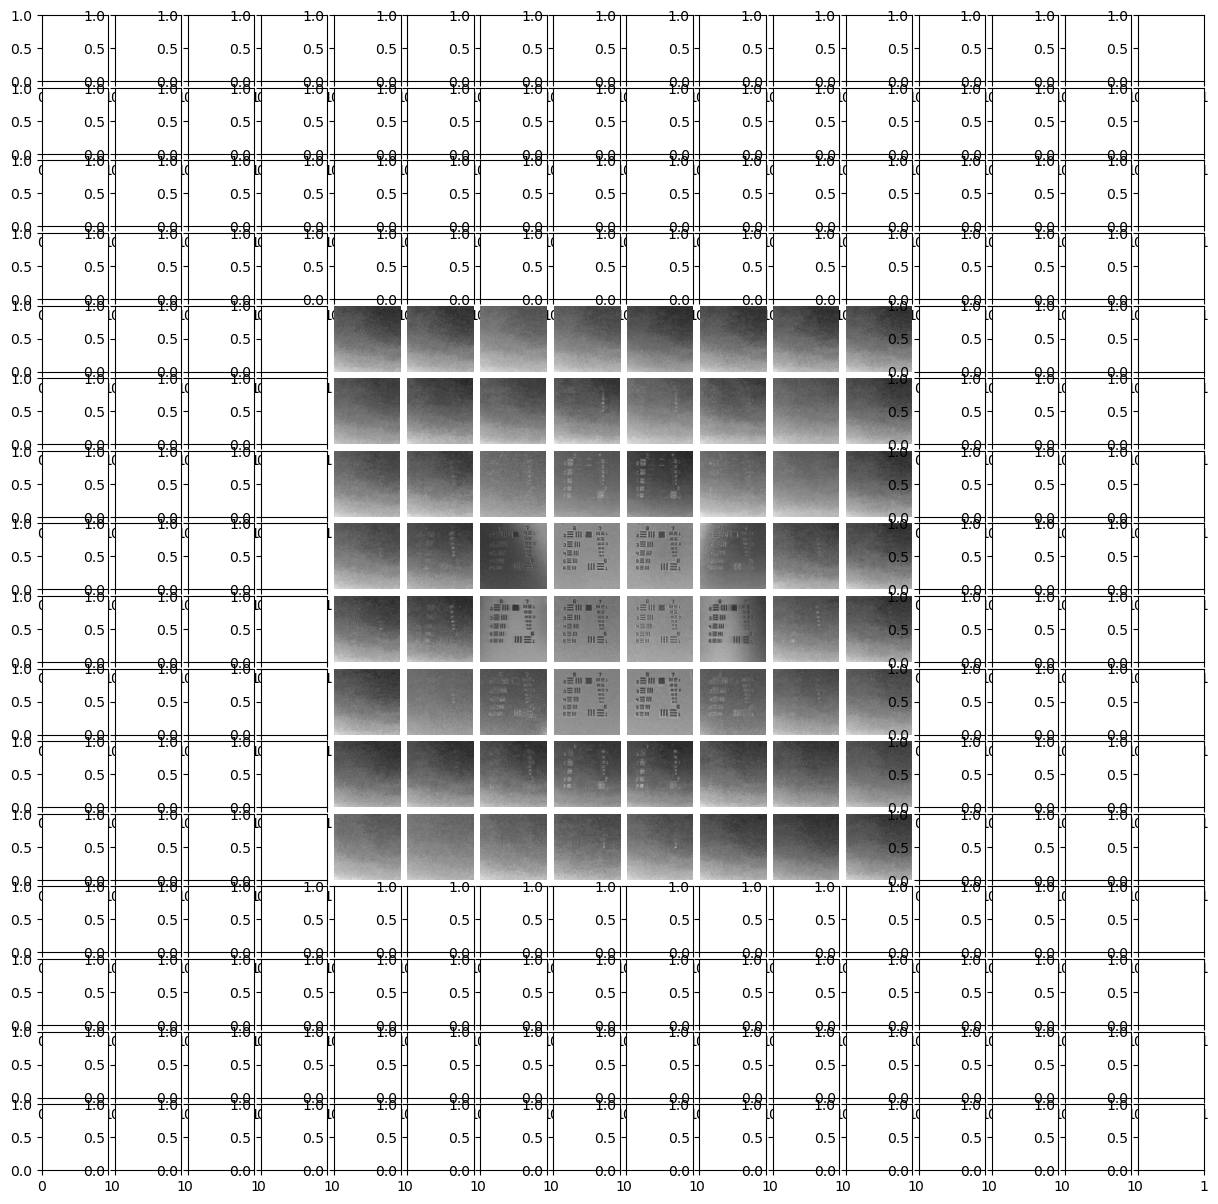

In [31]:
# Display 16x16 images in a grid
output_folder = 'data/usaf_light'
gridSize = 8

x,y = LED_spiral(gridSize) # get the coordinates of LEDs

fig, axes = plt.subplots(16, 16, figsize=(15,15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)


for i in range(gridSize*gridSize):
    image = Image.open(os.path.join(output_folder,f'image_{i}.png'))
    row = y[i]
    col = x[i]
    axes[row,col].imshow(image, cmap='gray')
    axes[row,col].axis('off')